In [1]:
# Modules
import sys
import json
# Tested module
sys.path.append("/home/simon/Documents/REPO/Exact_laws")
sys.path.append("/home/simon/Documents/REPO/Simu/Rapport_simu_quantities")

from quantities_analysis import *
#from exact_laws.preprocessing.quantities import QUANTITIES
from exact_laws.preprocessing.process_on_oca_files import from_OCA_files_to_standard_h5_file,extract_quantities_from_OCA_file
from exact_laws.preprocessing.process_on_standard_h5_file import describ_file,extract_quantities_from_h5_file

import os
import numpy as np
import numexpr as ne
import pickle
import h5py as h5
import plotly.graph_objects as go
from scipy.optimize import curve_fit
import scipy as sp
%matplotlib widget

plt.rcParams['text.usetex'] = True
rc('xtick', labelsize=12) 
rc('ytick', labelsize=12) 
rc('font', size=15)

In [2]:
with open("../descript_oca_simu.json","r") as f:
    simu = json.load(f)['CGL5']['12800']
del(f)

In [3]:
simu

{'original_folder': '/home/simon/Documents/DATA/SIMULATIONS/OCA/data_simus_oca/CGL5/CGL5_12785-12800/',
 'cycle': 'cycle_1',
 'group_grid': '3Dgrid',
 'N': [512, 512, 1024],
 'kdi': 0.147,
 'theta': 75,
 'thrsh_forc_hi': 0.016,
 'thrsh_forc_lo': 0.015,
 'nu': 3e-11,
 'eta': 3e-11,
 'an_hd': 6,
 'a1_forc': 0.5,
 'alpha': 6,
 'ap0': 1,
 'B0': [0, 0, 1],
 'beta0': 1,
 'name': 'CGL5.12800'}

In [4]:
c = []
with h5.File(simu['original_folder']+'3Dfields_b.h5') as file_fb:
    for a in ['x','y','z']:
        c.append(file_fb[simu['group_grid']][a][1])
del(file_fb,a)

In [5]:
ffreq = []
for i in range(3):
    ffreq.append(np.fft.fftfreq(simu['N'][i])/c[i]*2*np.pi)
del i

In [6]:
kx, ky, kz = np.meshgrid(ffreq[0], ffreq[1], ffreq[2], indexing='ij')
kmod =  np.sqrt(kx*kx+ky*ky+kz*kz)
kperp =  np.sqrt(kx*kx+ky*ky)
del(kx,ky,kz)

In [7]:
kmax = np.max(kmod)
kmin = np.unique(np.sort(kmod.flatten()))[1]
kmaxperp = np.max(kperp)
kminperp = np.unique(np.sort(kperp.flatten()))[1]

In [7]:
axek = np.unique(np.logspace(0, np.log10(max(simu['N'])), 50, endpoint=True, dtype=int))*kmin
try : 
    print('ici')
    with open("./redgrid", "rb") as fp:   #Pickling
        kpoints = pickle.load(fp)
except : 
    print('ici2')
    lim = [axek[0]-1,]+list((axek[1:]+axek[:-1])/2)+[axek[-1],]
    kpoints = [[],]*len(axek)
    for i in range(len(ffreq[0])):
        for j in range(len(ffreq[1])):
            for k in range(int(len(ffreq[2])/2)+1):
                if kmod[i,j,k] < lim[int(len(axek)/2)]:
                    for a in range(len(axek)):
                        if kmod[i,j,k] > lim[a] and kmod[i,j,k] <= lim[a+1]:
                            kpoints[a]+=list(set([(i,j,k),(i,j,int((len(ffreq[2])-k)%len(ffreq[2])))]))
                            break
                else : 
                    for a in range(int(len(axek)/2),len(axek)):
                        if kmod[i,j,k] > lim[a] and kmod[i,j,k] <= lim[a+1]:
                            kpoints[a]+=list(set([(i,j,k),(i,j,int((len(ffreq[2])-k)%len(ffreq[2])))]))
                            break
    with open("./redgrid", "wb") as fp:   #Pickling
        pickle.dump(kpoints, fp)
                    


ici


In [11]:
axek = np.unique(np.logspace(0, np.log10(max(simu['N'])), 50, endpoint=True, dtype=int))*kmin
def reduction(tab,axek,ffreq,kmod):
    lim = [axek[0]-1,]+list((axek[1:]+axek[:-1])/2)+[axek[-1],]
    output = np.zeros(len(axek))
    count = np.zeros(len(axek))
    kpoints = [[],]*len(axek)
    for i in range(len(ffreq[0])):
        for j in range(len(ffreq[1])):
            for k in range(int(len(ffreq[2])/2)+1):
                if kmod[i,j,k] < lim[int(len(axek)/2)]:
                    for a in range(len(axek)):
                        if kmod[i,j,k] > lim[a] and kmod[i,j,k] <= lim[a+1]:
                            for vect in set([(i,j,k),(i,j,int((len(ffreq[2])-k)%len(ffreq[2])))]):
                                output[a] += tab[vect[0],vect[1],vect[2]]
                                count[a] += 1
                            break
                else : 
                    for a in range(int(len(axek)/2),len(axek)):
                        if kmod[i,j,k] > lim[a] and kmod[i,j,k] <= lim[a+1]:
                            for vect in set([(i,j,k),(i,j,int((len(ffreq[2])-k)%len(ffreq[2])))]):
                                output[a] += tab[vect[0],vect[1],vect[2]]
                                count[a] += 1
                            break
    return output/count

In [8]:
def reduction4(tab,kpoints):
    tabred = np.zeros((len(kpoints)))
    for r in range(len(kpoints)):
        for e in kpoints[r]:
            tabred[r] += tab[e[0],e[1],e[2]]
        tabred[r]/= len(kpoints[r])
    return tabred

# Spectre vf

In [36]:
name_file = from_OCA_files_to_standard_h5_file(
        input_folder=simu['original_folder'],
        output_folder="/home/simon/Documents/DATA/SIMULATIONS/OCA/Quantities_analysis/OCA_CGL5.12800_analysis/",
        name="OCA_CGL5.12800_an",
        sim_type="OCA_CGL5",
        cycle=simu['cycle'],
        quantities=['v','f','hdk2','rho'],
        laws=[],
        terms=[],
        reduction=1,
        physical_params={k:simu[k] for k in simu if not k in ['cycle','N','B','name']},)

vx,vy,vz,rho,hdkx,hdky,hdkz,fx,fy,fz = extract_quantities_from_h5_file(name_file,['vx','vy','vz','rho','hdk2x','hdk2y','hdk2z','fx','fy','fz'])

ERROR:root:The file already exists. Process impossible.


In [70]:
sys.path.append("/home/simon/Documents/REPO/Simu/Rapport_simu_exactlaw/notebook/")
from visualisation_tools import *

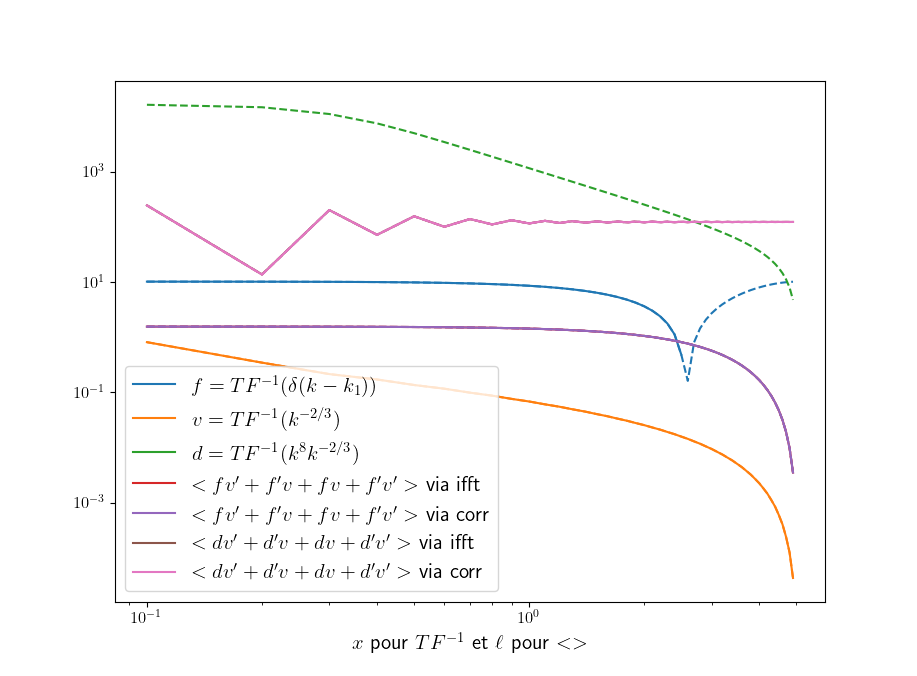

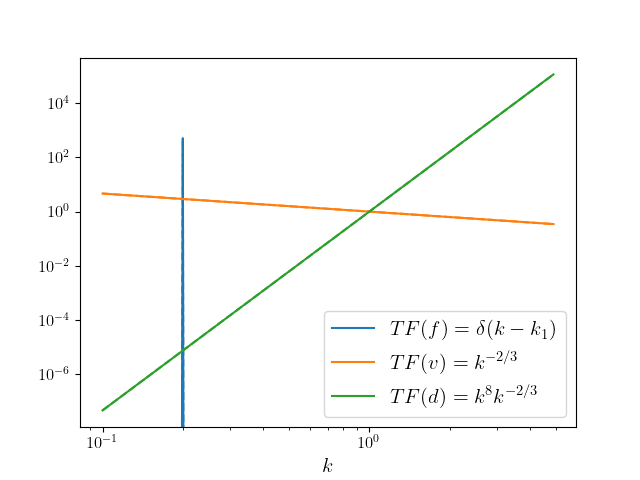

In [117]:
f = np.fft.fftfreq(100)[1:]/0.1

#forc = np.random.rand(len(f))
forc = np.zeros(len(f))
forc[1] = 500
forc[-1] = 500
v = np.abs(f)**(-2/3)
dissv = np.abs(f)**(8)*v
ifftforc = np.real(np.fft.ifft(forc))
ifftv = np.real(np.fft.ifft(v))
ifftdiss = np.real(np.fft.ifft(dissv))
corrvf = np.correlate(np.concatenate((ifftforc,ifftforc)),ifftv,"valid")[:-1] + np.correlate(np.concatenate((ifftv,ifftv)), ifftforc,'valid')[:-1]+2*np.sum(ifftforc*ifftv)
ifftvf = np.real(np.fft.ifft(forc*np.conj(v)+np.conj(forc)*v))+2*np.sum(ifftforc*ifftv)
ifftvdiss = np.real(np.fft.ifft(dissv*np.conj(v)+np.conj(dissv)*v))+2*np.sum(ifftdiss*ifftv)
corrvd = np.correlate(np.concatenate((ifftdiss,ifftdiss)),ifftv,"valid")[:-1] + np.correlate(np.concatenate((ifftv,ifftv)), ifftdiss,'valid')[:-1]+2*np.sum(ifftdiss*ifftv)

plt.figure(122)
plt.clf()
plt.yscale('log')
plt.xscale('log')
splot(np.arange(1,len(f)//2+1,1)*0.1,ifftforc[:len(f)//2],label='$f=TF^{-1}(\delta(k-k_1))$')
splot(np.arange(1,len(f)//2+1,1)*0.1,(ifftv)[:len(f)//2],label='$v=TF^{-1}(k^{-2/3})$')
splot(np.arange(1,len(f)//2+1,1)*0.1,(ifftdiss)[:len(f)//2],label='$d=TF^{-1}(k^8 k^{-2/3})$')
splot(np.arange(1,len(f)//2+1,1)*0.1,((ifftvf)/len(f))[:len(f)//2],label="$<fv'+f'v+fv+f'v'>$ via ifft")
splot(np.arange(1,len(f)//2+1,1)*0.1,((corrvf)/len(f))[:len(f)//2],label="$<fv'+f'v+fv+f'v'>$ via corr")
splot(np.arange(1,len(f)//2+1,1)*0.1,((ifftvdiss)/len(f))[:len(f)//2],label="$<dv'+d'v+dv+d'v'>$ via ifft")
splot(np.arange(1,len(f)//2+1,1)*0.1,((corrvd)/len(f))[:len(f)//2],label="$<dv'+d'v+dv+d'v'>$ via corr")

plt.xlabel("$x$ pour $TF^{-1}$ et $\ell$ pour $<>$")
plt.legend()
plt.show()
plt.figure(123)
plt.clf()
plt.yscale('log')
plt.xscale('log')
splot(f[:len(f)//2],forc[:len(f)//2],label='$TF(f)=\delta(k-k_1)$')
splot(f[:len(f)//2],v[:len(f)//2],label='$TF(v)=k^{-2/3}$')
splot(f[:len(f)//2],dissv[:len(f)//2],label='$TF(d)=k^8 k^{-2/3}$')
plt.xlabel("$k$ ")
plt.legend()
plt.show()


In [43]:

I[:256,0,0]

array([ 8.89127046e+04-0.00000000e+00j, -2.06995887e+04+2.45030200e+04j,
        4.76290110e+04-1.07919229e+04j,  1.37973253e+04-2.30737196e+03j,
        2.32772791e+04+1.43839103e+03j, -5.69205457e+02-5.13817023e+03j,
       -5.33205029e+03-1.10043346e+03j, -5.12961384e+03-5.65023594e+03j,
        3.57610896e+02-3.57600222e+03j, -3.09596235e+02+3.09296426e+03j,
        3.10588991e+03-1.04534638e+03j,  5.28658210e+02-1.30460604e+02j,
       -2.18456804e+03-9.45705023e+02j, -1.94052799e+03+7.05420281e+01j,
       -1.20762785e+03+7.72324597e+02j, -1.08898033e+02-2.90857352e+02j,
       -1.01113305e+03+3.12563764e+02j,  6.32909746e+02-1.04483818e+03j,
        8.39194014e+02-1.41860781e+03j, -1.14529967e+03+2.51217847e+02j,
       -8.87465184e+02+5.97275878e+02j, -2.20967236e+02-4.35789930e+02j,
        3.90397824e+02+1.18022213e+03j, -2.14042456e+02-7.32847317e+02j,
       -1.86718681e+02+1.34300053e+02j, -2.85503332e+02+1.80320530e+02j,
       -1.04132836e+02-3.16341642e+01j,  2.88579540

: 

In [13]:
try : 
    print('ici')
    with open("./fvf", "rb") as fp:   #Pickling
        fvf = pickle.load(fp)
except:
    fvf = sp.fft.fftn(vx)*np.conj(sp.fft.fftn(fx))
    fvf += sp.fft.fftn(vy)*np.conj(sp.fft.fftn(fy))
    fvf += sp.fft.fftn(vz)*np.conj(sp.fft.fftn(fz))
    fvf = np.real(kmod*kmod*fvf)
    with open("./fvf", "wb") as fp:   #Pickling
        pickle.dump(fvf,fp)

ici


In [14]:
fvfred = reduction(np.real(fvf),axek,ffreq,kmod)

In [26]:
itf = sp.fft.ifftn(np.real(fvf/kmod/kmod))

/tmp/ipykernel_84180/2049192197.py:1: RuntimeWarning: invalid value encountered in true_divide
  itf = sp.fft.ifftn(np.real(fvf/kmod/kmod))


In [35]:
itf[4,2,1]

(nan+6.217248937900877e-15j)

In [24]:
fvf[1,1,1],fvf[1,0,1],kmin

((-6156027660.372086+172024303.0804452j),
 (2347008735.9690638+372885530.54349965j),
 0.039401103230890466)

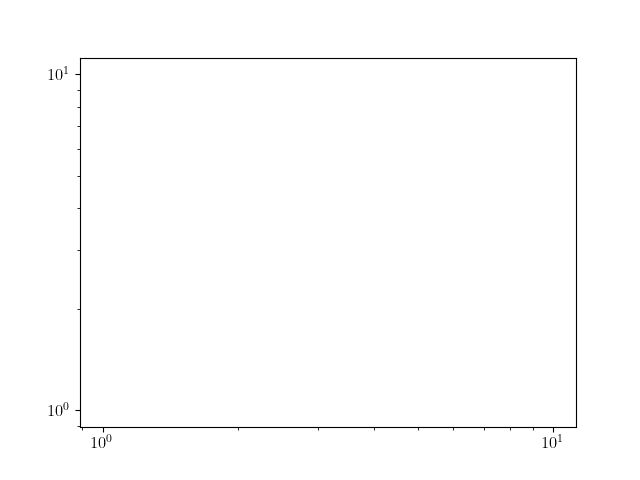

In [30]:
plt.figure(1)
plt.clf()
plt.xscale('log')
plt.yscale('log')
#plt.plot(axek,np.abs(fvfred))
#plt.plot(ffreq[0][1:256],np.abs(fvf[0,1:256,1]))
plt.plot(np.abs(ffreq[0][:]),np.abs(itf[0,:,0]))
plt.show()

# spectre B

In [ ]:
with h5.File(simu['original_folder']+'3Dfields_b.h5') as file_fb: 
    bx = np.transpose(np.ascontiguousarray(file_fb[simu['cycle']]['bx']))
    by = np.transpose(np.ascontiguousarray(file_fb[simu['cycle']]['by']))
    bz = np.transpose(np.ascontiguousarray(file_fb[simu['cycle']]['bz']))

In [22]:
spectre_oca = np.transpose(np.loadtxt(simu['original_folder']+'Spec1D_perp_B.dat'))

FileNotFoundError: /home/simon/Documents/DATA/SIMULATIONS/OCA/data_simus_oca/CGL5/CGL5_10000-10600_diss7e9/Spec1D_perp_B.dat not found.

In [11]:
fbx = np.fft.fftn(bx)
fby = np.fft.fftn(by)
fbz = np.fft.fftn(bz)

In [12]:
fb = np.abs(fbx*np.conj(fbx)+fby*np.conj(fby)+fbz*np.conj(fbz))
fbperp = np.abs(fbx*np.conj(fbx)+fby*np.conj(fby))

In [13]:
del(bx,by,bz,fbx,fby,fbz)

In [14]:
k = np.unique(np.logspace(0, np.log10(max(simu['N'])), 100, endpoint=True, dtype=int))*kmin
spectre_B = np.zeros(len(k))
spectre_Bperp = np.zeros(len(k))
kmodflat = kmod.flatten()
fbflat = fb.flatten()
fbperpflat = fbperp.flatten()
for i in range(1,len(spectre_B)-1):
    spectre_B[i] = np.nanmean(np.where(((kmodflat<(k[i+1]+k[i])/2) & (kmodflat>=(k[i]+k[i-1])/2)), fbflat, np.nan))
    spectre_Bperp[i] = np.nanmean(np.where(((kmodflat<(k[i+1]+k[i])/2) & (kmodflat>=(k[i]+k[i-1])/2)), fbperpflat, np.nan))
spectre_B[0] = np.nanmean(np.where(((kmodflat<(k[1]+k[0])/2) & (kmodflat>=k[0])), fbflat, np.nan))
spectre_B[-1] = np.nanmean(np.where(((kmodflat<=k[-1]) & (kmodflat>=(k[-1]+k[-2])/2)), fbflat, np.nan))
spectre_Bperp[0] = np.nanmean(np.where(((kmodflat<(k[1]+k[0])/2) & (kmodflat>=k[0])), fbperpflat, np.nan))
spectre_Bperp[-1] = np.nanmean(np.where(((kmodflat<=k[-1]) & (kmodflat>=(k[-1]+k[-2])/2)), fbperpflat, np.nan))
spectre_B = 2*np.pi*k*k*spectre_B
spectre_Bperp = 2*np.pi*k*k*spectre_Bperp

In [15]:
kp = np.unique(np.logspace(0, np.log10(max(simu['N'])), 100, endpoint=True, dtype=int))*kminperp
spectreperp_B = np.zeros((len(kp),np.shape(fb)[2]))
spectreperp_Bperp = np.zeros((len(kp),np.shape(fbperp)[2]))
for z in range(np.shape(fb)[2]):
    kperpflat = kperp[:,:,z].flatten()
    fbflat = fb[:,:,z].flatten()
    fbperpflat = fbperp[:,:,z].flatten()
    for i in range(1,len(kp)-1):
        spectreperp_B[i,z] = np.nanmean(np.where(((kperpflat<(kp[i+1]+kp[i])/2) & (kperpflat>=(kp[i]+kp[i-1])/2)), fbflat, np.nan))
        spectreperp_Bperp[i,z] = np.nanmean(np.where(((kperpflat<(kp[i+1]+kp[i])/2) & (kperpflat>=(kp[i]+kp[i-1])/2)), fbperpflat, np.nan))
    spectreperp_B[0,z] = np.nanmean(np.where(((kperpflat<(kp[1]+kp[0])/2) & (kperpflat>=kp[0])), fbflat, np.nan))
    spectreperp_B[-1,z] = np.nanmean(np.where(((kperpflat<=kp[-1]) & (kperpflat>=(kp[-1]+kp[-2])/2)), fbflat, np.nan))
    spectreperp_B[:,z] = np.pi*kp*spectreperp_B[:,z]
    spectreperp_Bperp[0,z] = np.nanmean(np.where(((kperpflat<(kp[1]+kp[0])/2) & (kperpflat>=kp[0])), fbperpflat, np.nan))
    spectreperp_Bperp[-1,z] = np.nanmean(np.where(((kperpflat<=kp[-1]) & (kperpflat>=(kp[-1]+kp[-2])/2)), fbperpflat, np.nan))
    spectreperp_Bperp[:,z] = np.pi*kp*spectreperp_Bperp[:,z]

/tmp/ipykernel_10364/1002481283.py:9: RuntimeWarning: Mean of empty slice
  spectreperp_B[i,z] = np.nanmean(np.where(((kperpflat<(kp[i+1]+kp[i])/2) & (kperpflat>=(kp[i]+kp[i-1])/2)), fbflat, np.nan))
/tmp/ipykernel_10364/1002481283.py:10: RuntimeWarning: Mean of empty slice
  spectreperp_Bperp[i,z] = np.nanmean(np.where(((kperpflat<(kp[i+1]+kp[i])/2) & (kperpflat>=(kp[i]+kp[i-1])/2)), fbperpflat, np.nan))
/tmp/ipykernel_10364/1002481283.py:12: RuntimeWarning: Mean of empty slice
  spectreperp_B[-1,z] = np.nanmean(np.where(((kperpflat<=kp[-1]) & (kperpflat>=(kp[-1]+kp[-2])/2)), fbflat, np.nan))
/tmp/ipykernel_10364/1002481283.py:15: RuntimeWarning: Mean of empty slice
  spectreperp_Bperp[-1,z] = np.nanmean(np.where(((kperpflat<=kp[-1]) & (kperpflat>=(kp[-1]+kp[-2])/2)), fbperpflat, np.nan))


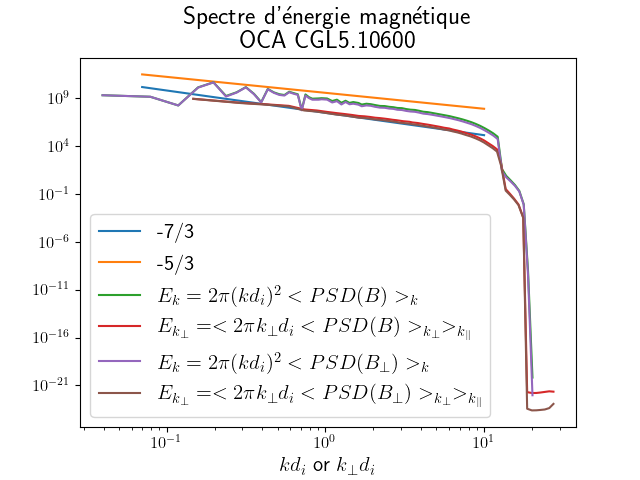

In [20]:
plt.figure(1)
plt.clf()
plt.xscale('log')
plt.yscale('log')
plt.title(f"Spectre d'énergie magnétique \n OCA {simu['name']}" )
#for z in range(np.shape(fb)[2]):
    #plt.plot(kp,spectreperp[:,z])
x = np.linspace(0.07,10,10)
plt.plot(x,3e7*x**(-7/3),label='-7/3')
plt.plot(x,3.7e9*x**(-5/3),label='-5/3')
#plt.plot(spectre_oca[0],spectre_oca[1]*1e13,label='OCA * $10^{13}$')
plt.plot(k,spectre_B,label='$E_k = 2\\pi (kd_i)^2 <PSD(B)>_{k}$')
plt.plot(kp,np.mean(spectreperp_B,axis=1),label='$E_{k_{\\perp}} = <2\\pi k_{\\perp} d_i <PSD(B)>_{k_{\\perp}}>_{k_{\\parallel}}$')
plt.plot(k,spectre_Bperp,label='$E_k = 2\\pi (kd_i)^2 <PSD(B_{\perp})>_{k}$')
plt.plot(kp,np.mean(spectreperp_Bperp,axis=1),label='$E_{k_{\\perp}} = <2\\pi k_{\\perp} d_i <PSD(B_{\perp})>_{k_{\\perp}}>_{k_{\\parallel}}$')

plt.xlabel('$kd_i$ or $k_{\\perp} d_i$')
plt.legend(loc='lower left')
plt.show()

# spectre V

In [23]:
with h5.File(simu['original_folder']+'3Dfields_v.h5') as file_fb: 
    vx = np.transpose(np.ascontiguousarray(file_fb[simu['cycle']]['vx']))
    vy = np.transpose(np.ascontiguousarray(file_fb[simu['cycle']]['vy']))
    vz = np.transpose(np.ascontiguousarray(file_fb[simu['cycle']]['vz']))

In [24]:
fvx = np.fft.fftn(vx)
fvy = np.fft.fftn(vy)
fvz = np.fft.fftn(vz)

In [25]:
fv = np.abs(fvx*np.conj(fvx)+fvy*np.conj(fvy)+fvz*np.conj(fvz))
fvperp = np.abs(fvx*np.conj(fvx)+fvy*np.conj(fvy))

In [26]:
del(vx,vy,vz,fvx,fvy,fvz)

In [27]:
k = np.unique(np.logspace(0, np.log10(max(simu['N'])), 100, endpoint=True, dtype=int))*kmin
spectre_V = np.zeros(len(k))
spectre_Vperp = np.zeros(len(k))
kmodflat = kmod.flatten()
fvflat = fv.flatten()
fvperpflat = fvperp.flatten()
for i in range(1,len(spectre_V)-1):
    spectre_V[i] = np.nanmean(np.where(((kmodflat<(k[i+1]+k[i])/2) & (kmodflat>=(k[i]+k[i-1])/2)), fvflat, np.nan))
    spectre_Vperp[i] = np.nanmean(np.where(((kmodflat<(k[i+1]+k[i])/2) & (kmodflat>=(k[i]+k[i-1])/2)), fvperpflat, np.nan))
spectre_V[0] = np.nanmean(np.where(((kmodflat<(k[1]+k[0])/2) & (kmodflat>=k[0])), fvflat, np.nan))
spectre_V[-1] = np.nanmean(np.where(((kmodflat<=k[-1]) & (kmodflat>=(k[-1]+k[-2])/2)), fvflat, np.nan))
spectre_Vperp[0] = np.nanmean(np.where(((kmodflat<(k[1]+k[0])/2) & (kmodflat>=k[0])), fvperpflat, np.nan))
spectre_Vperp[-1] = np.nanmean(np.where(((kmodflat<=k[-1]) & (kmodflat>=(k[-1]+k[-2])/2)), fvperpflat, np.nan))
spectre_V = 2*np.pi*k*k*spectre_V
spectre_Vperp = 2*np.pi*k*k*spectre_Vperp

In [28]:
kp = np.unique(np.logspace(0, np.log10(max(simu['N'])), 100, endpoint=True, dtype=int))*kminperp
spectreperp_V = np.zeros((len(kp),np.shape(fv)[2]))
spectreperp_Vperp = np.zeros((len(kp),np.shape(fvperp)[2]))
for z in range(np.shape(fv)[2]):
    kperpflat = kperp[:,:,z].flatten()
    fvflat = fv[:,:,z].flatten()
    fvperpflat = fvperp[:,:,z].flatten()
    for i in range(1,len(kp)-1):
        spectreperp_V[i,z] = np.nanmean(np.where(((kperpflat<(kp[i+1]+kp[i])/2) & (kperpflat>=(kp[i]+kp[i-1])/2)), fvflat, np.nan))
        spectreperp_Vperp[i,z] = np.nanmean(np.where(((kperpflat<(kp[i+1]+kp[i])/2) & (kperpflat>=(kp[i]+kp[i-1])/2)), fvperpflat, np.nan))
    spectreperp_V[0,z] = np.nanmean(np.where(((kperpflat<(kp[1]+kp[0])/2) & (kperpflat>=kp[0])), fvflat, np.nan))
    spectreperp_V[-1,z] = np.nanmean(np.where(((kperpflat<=kp[-1]) & (kperpflat>=(kp[-1]+kp[-2])/2)), fvflat, np.nan))
    spectreperp_V[:,z] = np.pi*kp*spectreperp_V[:,z]
    spectreperp_Vperp[0,z] = np.nanmean(np.where(((kperpflat<(kp[1]+kp[0])/2) & (kperpflat>=kp[0])), fvperpflat, np.nan))
    spectreperp_Vperp[-1,z] = np.nanmean(np.where(((kperpflat<=kp[-1]) & (kperpflat>=(kp[-1]+kp[-2])/2)), fvperpflat, np.nan))
    spectreperp_Vperp[:,z] = np.pi*kp*spectreperp_Vperp[:,z]

/tmp/ipykernel_10364/860732802.py:9: RuntimeWarning: Mean of empty slice
  spectreperp_V[i,z] = np.nanmean(np.where(((kperpflat<(kp[i+1]+kp[i])/2) & (kperpflat>=(kp[i]+kp[i-1])/2)), fvflat, np.nan))
/tmp/ipykernel_10364/860732802.py:10: RuntimeWarning: Mean of empty slice
  spectreperp_Vperp[i,z] = np.nanmean(np.where(((kperpflat<(kp[i+1]+kp[i])/2) & (kperpflat>=(kp[i]+kp[i-1])/2)), fvperpflat, np.nan))
/tmp/ipykernel_10364/860732802.py:12: RuntimeWarning: Mean of empty slice
  spectreperp_V[-1,z] = np.nanmean(np.where(((kperpflat<=kp[-1]) & (kperpflat>=(kp[-1]+kp[-2])/2)), fvflat, np.nan))
/tmp/ipykernel_10364/860732802.py:15: RuntimeWarning: Mean of empty slice
  spectreperp_Vperp[-1,z] = np.nanmean(np.where(((kperpflat<=kp[-1]) & (kperpflat>=(kp[-1]+kp[-2])/2)), fvperpflat, np.nan))


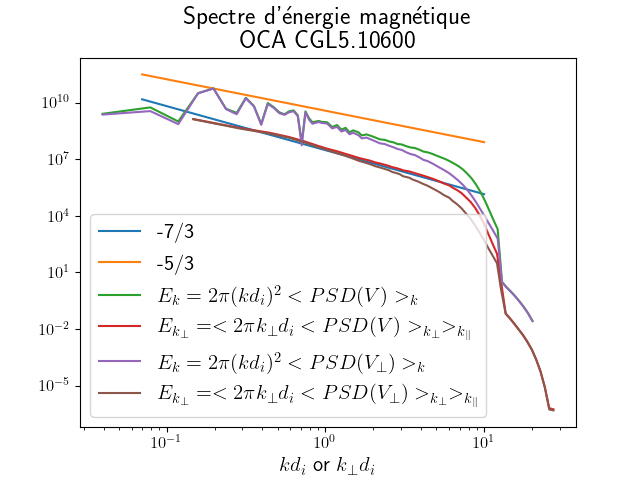

In [29]:
plt.figure(1)
plt.clf()
plt.xscale('log')
plt.yscale('log')
plt.title(f"Spectre d'énergie magnétique \n OCA {simu['name']}" )
#for z in range(np.shape(fb)[2]):
    #plt.plot(kp,spectreperp[:,z])
x = np.linspace(0.07,10,10)
plt.plot(x,3e7*x**(-7/3),label='-7/3')
plt.plot(x,3.7e9*x**(-5/3),label='-5/3')
#plt.plot(spectre_oca[0],spectre_oca[1]*1e13,label='OCA * $10^{13}$')
plt.plot(k,spectre_V,label='$E_k = 2\\pi (kd_i)^2 <PSD(V)>_{k}$')
plt.plot(kp,np.mean(spectreperp_V,axis=1),label='$E_{k_{\\perp}} = <2\\pi k_{\\perp} d_i <PSD(V)>_{k_{\\perp}}>_{k_{\\parallel}}$')
plt.plot(k,spectre_Vperp,label='$E_k = 2\\pi (kd_i)^2 <PSD(V_{\perp})>_{k}$')
plt.plot(kp,np.mean(spectreperp_Vperp,axis=1),label='$E_{k_{\\perp}} = <2\\pi k_{\\perp} d_i <PSD(V_{\perp})>_{k_{\\perp}}>_{k_{\\parallel}}$')

plt.xlabel('$kd_i$ or $k_{\\perp} d_i$')
plt.legend(loc='lower left')
plt.show()

In [4]:
import numpy as np

a = np.array([[3, 2, 0], [1, -1, 0], [0, 5, 1]])

b = np.array([2, 4, -1])

import scipy as sp

x = sp.linalg.solve(a, b)


In [5]:
timeit(sp.linalg.solve(a, b))

13 µs ± 110 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [6]:
timeit(np.linalg.solve(a, b))

4.87 µs ± 42.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
